# Data preparation

## Data loading

In [1]:
#
# Data Loading
#

from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), 133)
    return files, targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dataset/train')
valid_files, valid_targets = load_dataset('dataset/val')
test_files, test_targets = load_dataset('dataset/test')

# load list of categories names
category_names = [item[14:-1] for item in sorted(glob("dataset/train/*/"))]

# print statistics about the dataset
print('There are %d total categories:' % len(category_names), str(category_names))
print('There are %s total images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training images.' % len(train_files))
print('There are %d validation images.' % len(valid_files))
print('There are %d test images.'% len(test_files))

Using TensorFlow backend.


There are 2 total categories: ['NORMAL', 'PNEUMONIA']
There are 5856 total images.

There are 5216 training images.
There are 16 validation images.
There are 624 test images.


## Data inspection

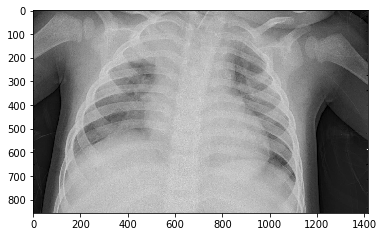

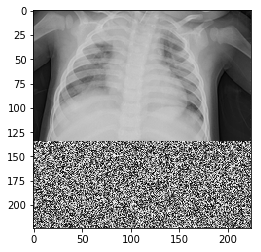

In [2]:
#
# Data Inspection
#

import cv2
import matplotlib.pyplot as plt                        
%matplotlib inline           

from PIL import Image                  

desired_size = 224
random_img = Image.fromarray(np.random.rand(desired_size, desired_size) * 255)
random_img = random_img.convert('RGB')

def path_to_image(img_path):
    img = random_img.copy()  # random content image (to ensure the proper size)
    original_img = Image.open(img_path)
    original_img.thumbnail((desired_size, desired_size), Image.LANCZOS)  # rescaled image (preserves aspect ratio)
    img.paste(original_img)
    return img

# display some sample images
for i in range(1):
    # original image
    plt.imshow(cv2.cvtColor(cv2.imread(train_files[i]), cv2.COLOR_BGR2RGB))
    plt.show()
    # show final image
    plt.imshow(cv2.cvtColor(np.asarray(path_to_image(train_files[i])), cv2.COLOR_BGR2RGB))
    plt.show()
    

## Data preprocessing

In [3]:
#
# Data Preprocessing
#

from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = path_to_image(img_path)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return (np.expand_dims(x, axis=0).astype('float16') - 128) / 255

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files)
valid_tensors = paths_to_tensor(valid_files)
test_tensors = paths_to_tensor(test_files)



100%|██████████| 624/624 [00:04<00:00, 132.88it/s]


# Custom CNN

In [4]:
#
# Experimenting with custom CNN built from scratch
#

from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(133, activation='softmax'))

model.summary()

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 64)        0         
__________

In [5]:
'''
from keras.callbacks import ModelCheckpoint

epochs = 4

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)
model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

model.load_weights('saved_models/weights.best.from_scratch.hdf5')

predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)
'''

Train on 5216 samples, validate on 16 samples
Epoch 1/4
5216/5216 [==============================] - 78s 15ms/step - loss: 0.2468 - acc: 0.9061 - val_loss: 0.4626 - val_acc: 0.6250

Epoch 00001: val_loss improved from inf to 0.46257, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/4
5216/5216 [==============================] - 72s 14ms/step - loss: 0.1169 - acc: 0.9582 - val_loss: 0.5778 - val_acc: 0.6250

Epoch 00002: val_loss did not improve from 0.46257
Epoch 3/4
5216/5216 [==============================] - 70s 13ms/step - loss: 0.0912 - acc: 0.9632 - val_loss: 0.7098 - val_acc: 0.6250

Epoch 00003: val_loss did not improve from 0.46257
Epoch 4/4
5216/5216 [==============================] - 70s 13ms/step - loss: 0.0772 - acc: 0.9695 - val_loss: 0.6801 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 0.46257
Test accuracy: 79.3269%


# Transfer learning